In [1]:
import torch
import torch.nn as nn

class Conv1d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize the weights and biases
        self.weights = torch.randn(out_channels, in_channels, kernel_size)
        self.biases = torch.zeros(out_channels)

    def forward(self, x):
        batch_size, in_channels, width = x.shape

        # Calculate the output dimensions
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        # Create an empty tensor for the output
        out = torch.zeros(batch_size, self.out_channels, out_width)

        # Perform the convolution
        for i in range(self.out_channels):
            for j in range(out_width):
                out[:, i, j] = torch.sum(x[:, :, j * self.stride:j * self.stride + self.kernel_size] * self.weights[i, :, :]) + self.biases[i]

        return out    

class CNN_Network(nn.Module):
    def __init__(self,input_size, sequence_length, output_size):
        super(CNN_Network, self).__init__()
        self.conv1 = Conv1d(in_channels=sequence_length, out_channels=32, kernel_size=2)
        self.conv2 = Conv1d(in_channels=32, out_channels=16, kernel_size=2)
        self.fc1 = nn.Linear(16 * 4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = torch.relu(self.conv1.forward(x))
        x = torch.relu(self.conv2.forward(x))
        x = x.view(-1, 16 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
from config import *
from load_data import getTrainingSet


dataset = getTrainingSet(reshape=False, sequence_length=24)
features = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
input_size = features
output_size = OUTPUT_SIZE
epochs = CNN_EPOCHS
learning_rate = CNN_LEARNING_RATE
l2_rate = L2_REGULARIZATION_RATE
batch_size = BATCH_SIZE

model = CNN_Network(input_size, sequence_length, output_size)
loss_function = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_rate)

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998


In [3]:
def train(model, dataset, loss_function, optimizer, batch_size, epochs,save_model=False):
    # Set the model to training mode
    model.train()

    # Create data loader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    losses = []
    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        # Iterate over the data loader
        for inputs, labels in data_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            labels = labels.view(-1, 1)
            loss = loss_function(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the running loss
            running_loss += loss.item()

        losses.append(running_loss/len(data_loader))
        # Print the average loss for the epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {losses[-1]}")

    if save_model:
        torch.save(model.state_dict(), "trained_models/cnn_trained_model.pth")
        print("Model saved.")
    return losses



In [4]:
losses = train(model, dataset, loss_function, adam, batch_size, epochs, save_model=True)

Epoch 1/10, Loss: 70729.86015297884
Epoch 2/10, Loss: 161.78152776762747
Epoch 3/10, Loss: 34.414695083439
Epoch 4/10, Loss: 44.17893816904253
Epoch 5/10, Loss: 3.562214754181948
Epoch 6/10, Loss: 1.7427311773534293
Epoch 7/10, Loss: 1.3933348118278273
Epoch 8/10, Loss: 1.4039352390622843
Epoch 9/10, Loss: 1.4227042716577731
Epoch 10/10, Loss: 2.9096612304102383
Model saved.


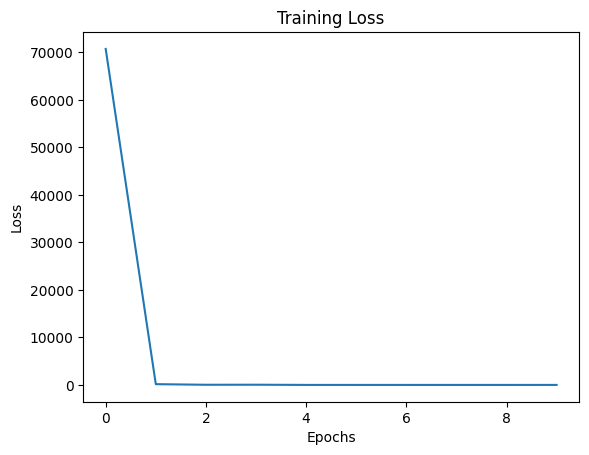

In [5]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [6]:
import random
import numpy as np

def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon])
            x = x.view(1, *x.shape)
            output = model.forward(x)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions

def plot_predictions(predictions, targets, y_scaler):
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    targets = y_scaler.inverse_transform(targets.reshape(-1, 1))
    plt.plot([i for i in range(23,47)], predictions, label='Predictions')
    
    plt.plot(targets[0:48], label='Targets')
    plt.legend()
    plt.show()

def average_error_over_horizons(model, X_test, y_test, forecast_horizon,y_scaler,random_samples=5):
    errors = []
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), random_samples)
    
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        error = np.mean(np.square(preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]))
        errors.append(error)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon], y_scaler)
    return np.mean(errors)


In [9]:
from load_data import getTestData
import numpy as np

model.load_state_dict(torch.load('trained_models/cnn_trained_model.pth'))
model.eval()

data = getTestData()
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998


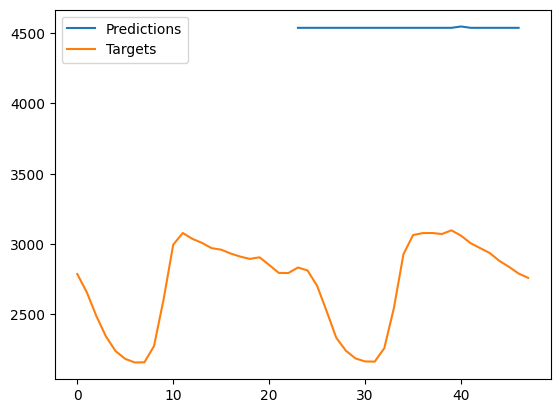

In [10]:
preds=predict_one_horizon(model, data[0][:48], 24, 24)
plot_predictions(preds, data[1],y_scaler)

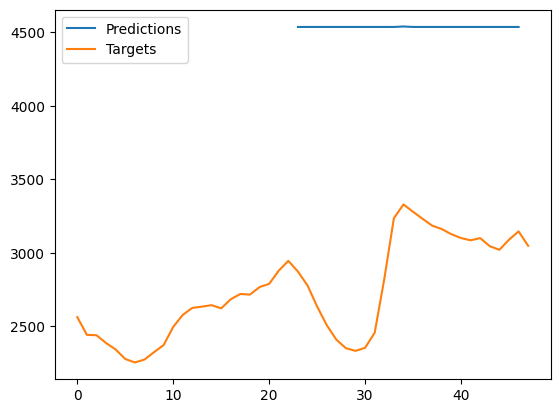

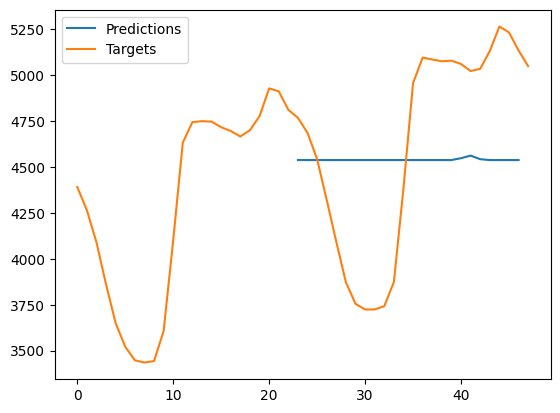

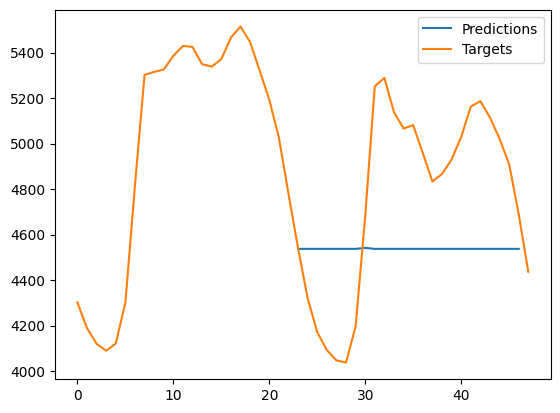

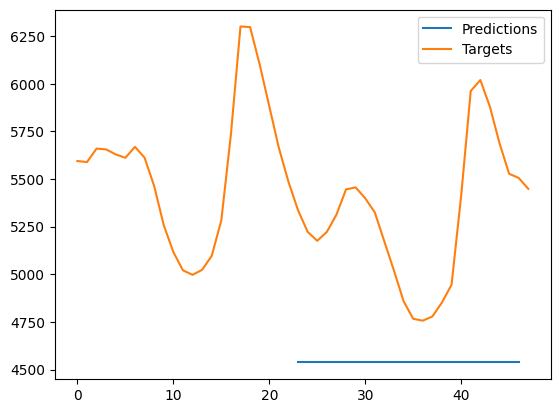

KeyboardInterrupt: 

In [11]:
print(average_error_over_horizons(model, data[0], data[1], 24, y_scaler, random_samples=5))